<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction </b> </p>

## Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

## Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [1]:
import csv
import pandas as pd # pandas to create small dataframes 
import datetime # Convert to unix time
import time # Convert to unix time
import numpy as np
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
from sklearn.model_selection import train_test_split
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pathlib import Path

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
path = Path('../data/facebook')
list(path.iterdir())

[PosixPath('../data/facebook/test_y.csv'),
 PosixPath('../data/facebook/train_woheader_sample.csv'),
 PosixPath('../data/facebook/._test_y.csv'),
 PosixPath('../data/facebook/after_eda'),
 PosixPath('../data/facebook/train.csv'),
 PosixPath('../data/facebook/fea_sample'),
 PosixPath('../data/facebook/._fea_sample'),
 PosixPath('../data/facebook/._train_y.csv'),
 PosixPath('../data/facebook/._after_eda'),
 PosixPath('../data/facebook/._train.csv'),
 PosixPath('../data/facebook/train_y.csv')]

In [4]:
df = pd.read_csv(path/'train.csv')
print(df.shape)
df.head()

(9437519, 2)


,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
source_node         int64
destination_node    int64
dtypes: int64(2)
memory usage: 144.0 MB


In [6]:
df[df.isnull().any(1)]

,source_node,destination_node


In [7]:
sum(df.duplicated())

0

In [8]:
graph=nx.read_edgelist(path/'after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


### Displaying a sub-graph of the parent graph

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


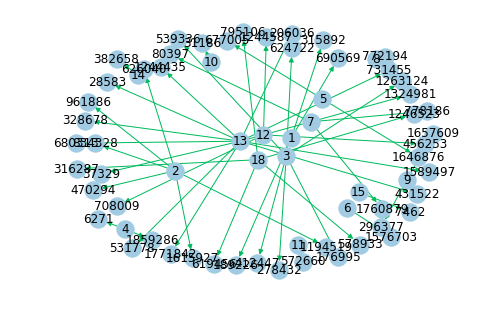

In [9]:
pd.read_csv(path/'train.csv', nrows=50).to_csv(path/'train_woheader_sample.csv',header=False,index=False)

subgraph = nx.read_edgelist(path/'train_woheader_sample.csv', delimiter=',', create_using=nx.DiGraph(),nodetype=int)


pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color='#A0CBE2', edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)

plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))


##  Exploratory Data Analysis

In [10]:
print("The number of unique persons",len(graph.nodes()))

The number of unique persons 1862220


## No of followers for each person

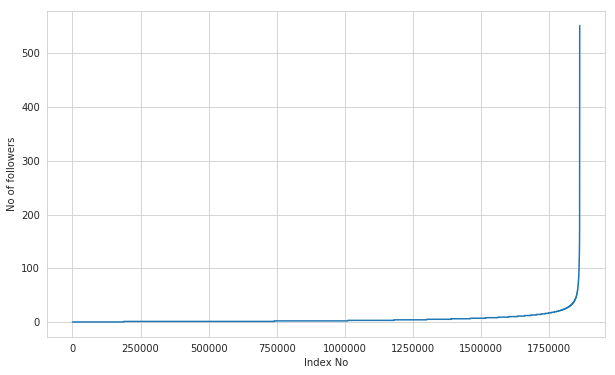

In [11]:
indegree_dist = list(dict(graph.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of followers')
plt.show()

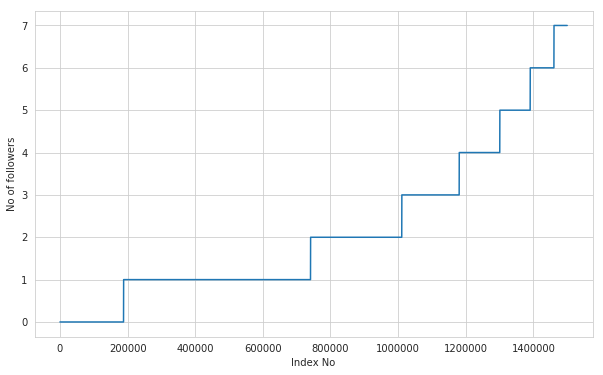

In [12]:
indegree_dist = list(dict(graph.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No of followers')
plt.show()

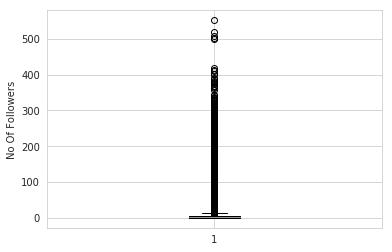

In [13]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [14]:
for i in range(11):
    print(f'{90+i} percentile value is {np.percentile(indegree_dist, 90+i)}')

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


- 99% of data having followers of 40 only.

In [15]:
for i in range(10, 110, 10):
    print(f'{99 + (i/100)} percentile value is {np.percentile(indegree_dist, 99 + (i/100)) }')
                                              
                                              
                                              

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


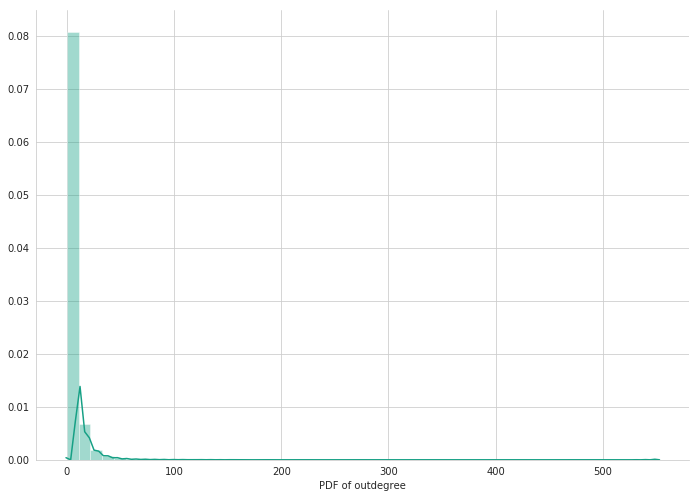

In [16]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.distplot(indegree_dist, color='#16A085', ax=ax)
ax.set_xlabel('PDF of outdegree')
sns.despine(ax=ax)

### No of people each person is following

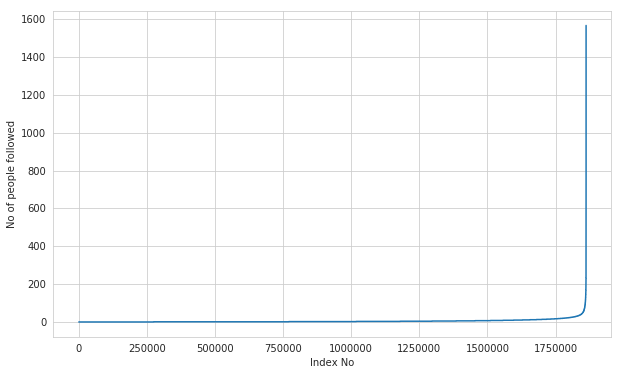

In [17]:
outdegree_dist = list(dict(graph.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No of people followed')
plt.show()

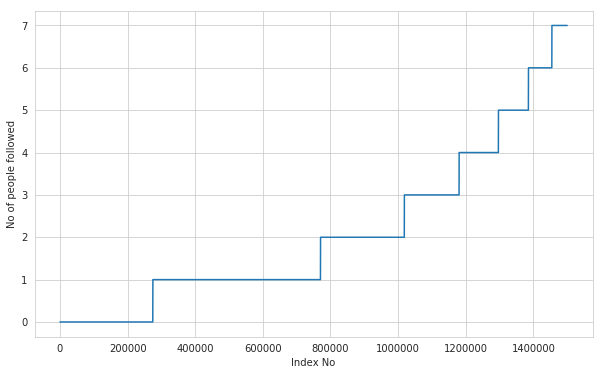

In [18]:
outdegree_dist = list(dict(graph.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(outdegree_dist[:1500000])
plt.xlabel('Index No')
plt.ylabel('No of people followed')
plt.show()

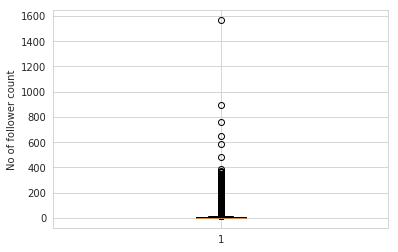

In [19]:
plt.boxplot(outdegree_dist)
plt.ylabel('No of follower count')
plt.show()

In [20]:
for i in range(90, 101):
    print(f'{i} percentile value is {np.percentile(outdegree_dist, i)}')

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [21]:
for i in range(1, 11):
    print(f'{99 + (i/10)} percentile value is {np.percentile(outdegree_dist, 99 + (i/10))}')

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


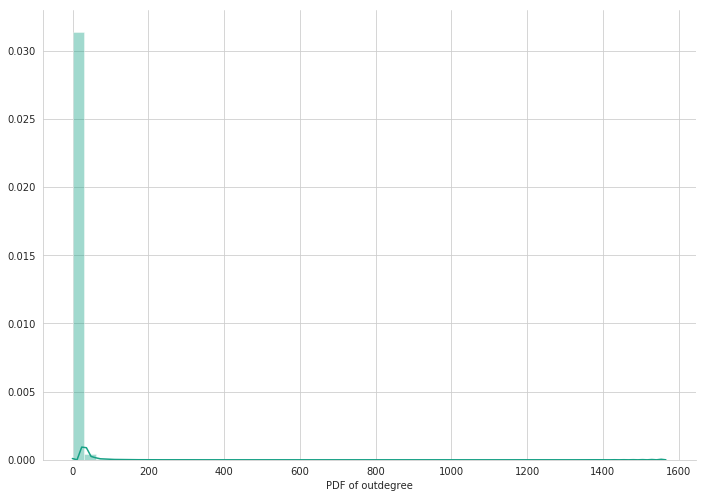

In [22]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.distplot(outdegree_dist, color='#16A085', ax=ax)
ax.set_xlabel('PDF of outdegree')
sns.despine(ax=ax)

In [23]:
no_following = sum(np.array(outdegree_dist)==0)
print('No of persons those are not following anyone are' ,no_following,'and % is',
                                round(no_following*100/len(outdegree_dist), 2) )

No of persons those are not following anyone are 274512 and % is 14.74


In [24]:
no_followers = sum(np.array(indegree_dist)==0)
print('No of persons those are not following anyone are' ,no_followers,'and % is',
                                round(no_followers*100/len(indegree_dist), 2) )


No of persons those are not following anyone are 188043 and % is 10.1


In [25]:
count=0
for i in graph.nodes():
    if len(list(graph.predecessors(i)))==0 :
        if len(list(graph.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


### both followers + following 

In [26]:
from collections import Counter
dict_in = dict(graph.in_degree())
dict_out = dict(graph.out_degree())
d = Counter(dict_in) + Counter(dict_out)

in_out_degree = np.array(list(d.values()))

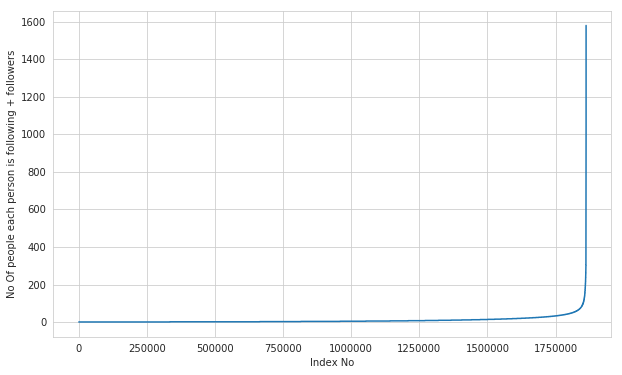

In [27]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

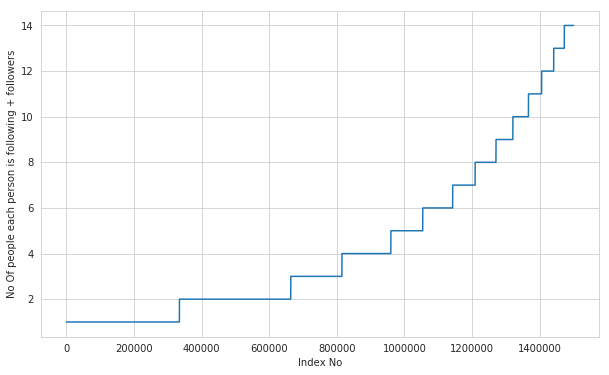

In [28]:
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [29]:
for i in range(90, 101):
    print(f'{i} percentile value is {np.percentile(in_out_degree_sort, i)}')

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [30]:
for i in range(1, 11):
    print(f'{99 + (i/10)} percentile value is {np.percentile(in_out_degree_sort, 99 + (i/10))}')

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


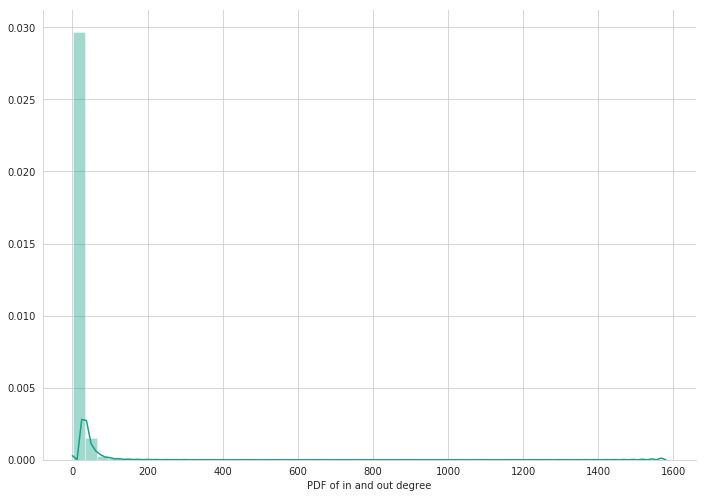

In [31]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.distplot(in_out_degree_sort, color='#16A085', ax=ax)
ax.set_xlabel('PDF of in and out degree')
sns.despine(ax=ax)

In [32]:
in_out_degree_sort = np.array(in_out_degree_sort)
print('Min no of followers and following is', in_out_degree_sort.min())
print('People having min number of follower and following', np.sum(in_out_degree_sort == in_out_degree_sort.min()))


print('Max no of followers and following is', in_out_degree_sort.max())
print('People having max number of follower and following', np.sum(in_out_degree_sort == in_out_degree_sort.max()))


Min no of followers and following is 1
People having min number of follower and following 334291
Max no of followers and following is 1579
People having max number of follower and following 1


In [33]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [34]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(graph))))
count=0

for i in list(nx.weakly_connected_components(graph)):
    if len(i) == 2:
        count += 1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


## Posing a problem as classification problem 

### Generating some edges which are not present in graph for supervised learning  


In [35]:
import random

In [ ]:
%%time
###generating bad edges from given graph
if not os.path.isfile(path/'after_eda/missing_edges_final.p'):
    r = csv.reader(open(path/'after_eda/train_woheader.csv', 'r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
    missing_edges = set([])
    while len(missing_edges) < 9437519:
        a = random.randint(1, 1862220)
        b = random.randint(1, 1862220)
        tmp = edges.get((a, b), -1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(graph,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))
        else:
            continue
    pickle.dump(missing_edges,open(path/'after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open(path/'after_eda/missing_edges_final.p','rb'))
        

In [ ]:
len(missing_edges)

## Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [ ]:
if (not os.path.isfile(path/'after_eda/train_pos_after_eda.csv')) and (not os.path.isfile(path/'after_eda/test_pos_after_eda.csv')):

    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])

    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv(path/'after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv(path/'after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv(path/'after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv(path/'after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges


In [ ]:
if (os.path.isfile(path/'after_eda/train_pos_after_eda.csv')) and (os.path.isfile(path/'after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist(path/'after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist(path/'after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

In [ ]:
X_train_pos = pd.read_csv(path/'after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv(path/'after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv(path/'after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv(path/'after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])


In [ ]:
df_pos = pd.read_csv(path/'train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])

X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)


In [ ]:
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg))

In [ ]:
X_train.to_csv(path/'after_eda/train_after_eda.csv',header=False,index=False)
X_test.to_csv(path/'after_eda/test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv(path/'train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv(path/'test_y.csv',header=False,index=False)

In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)